# Analysis and Forecasting of Precipitation ERA5 land data of Mahad

## Problem Statement/Objectives


- I have chosen [ERA5-land hourly data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=form) for my project. 
- The **objective** is to find useful information about the weather in the Konkan area of Maharashtra, which receives the highest rainfall, leading to the floods. 
- If we are able to find useful patterns in the data that could help us forecast the precipitation in the future, even by an hour, it could help the people to better prepare for the flood. 
- The data is in `netCDF` file format. Hence, we can use `xarray` to read the data.

**Floods in Mahad**
- My hometown is Mahad, a small town in the Konkan district of Maharashtra, India. 
- On July 21 and July 22, 2021, the torrential rains had left `94` houses completely damaged and `9649` partially wrecked.
- About `3709` houses were damaged. 
- The landslide in **Taliye** village in the Mahad tehshil killed at least 84 people.

**The parameters that I have chosen are:**
- `10m_v_component_of_wind` or `v10` : northward component of the 10m wind, in `m/s` units, moving at a height of 10m above the surface,
- `2m_temperature` or `t2m`: the temperature of air at 2m above the surface, in `Kelvin` units,
- `surface_net_solar_radiation` or `ssr`: the amount of solar radiation that reaches a horizontal plane at the surface minus the amount reflected by the Earth's surface, in `W/m^2` units,
- `surface_pressure` or `sp`: pressue of the atmosphere on the surface of land, in `Pa` units,
- `total_precipitation` or `tp`: the accumulated liquid and frozen water, comprising rain and snow, that falls to the surface in `m` units.

**Further information about the floods in Mahad and the havoc it caused**
- https://www.business-standard.com/article/current-affairs/maha-over-9-700-houses-45-buildings-damaged-in-mahad-due-to-july-floods-121081301002_1.html#:~:text=A%20total%20of%2045%20buildings,occurred%20on%20July%2021%2D22. 



## Data Collection.

- This is explained in `data_collection.ipynb` file.

### Install required libraries and [Contourf and cartopy issues resolved](https://linuxtut.com/en/8f0d69169dc6ab753e08/)

In [1]:
!pip install xarray
!pip install cartopy

!grep '^deb ' /etc/apt/sources.list | \
  sed 's/^deb /deb-src /g' | \
  tee /etc/apt/sources.list.d/deb-src.list
!apt-get -qq update

!grep '^deb ' /etc/apt/sources.list | \
  sed 's/^deb /deb-src /g' | \
  tee /etc/apt/sources.list.d/deb-src.list
!apt-get update

!apt-get -qq build-dep python3-cartopy
!apt-get -qq remove python-shapely python3-shapely

!pip install --no-binary shapely shapely --force
!pip install --no-binary cartopy cartopy==0.19.0

!pip list | grep Shapely

     |████████████████████████████████| 10.8 MB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 24.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 43.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 42.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 2.0 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516278 sha256=02fc347d2403403e77cceaaf7550b1cd986d98db20cd04fe3af5a7e29fa4685e
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy
deb-src h

### Install libraries

In [2]:
import numpy as np  # import numpy package 
import matplotlib.pyplot as plt # function in matplotlib that produces quick and easy plots
import pandas as pd # load the Pandas module, which is a library for data manipulation of 2 dimensional data
import xarray as xr # load the xarray module, which is a library for data manipulation of N dimensional data
import cartopy.crs as ccrs # Cartopy map projections
import cartopy.feature as cfeature # Cartopy map features
from cartopy.util import add_cyclic_point
import cartopy
import warnings 
warnings.filterwarnings('ignore')

### Load data

* The data 'download.nc' had been downloaded using the 'data_collection.ipynb' file. I kept it as a separate file, because the website might keep changing the format of the data, time to time. I want the results to be consistent.


In [3]:
# open_dataset is one of the main functions in Xarray to open a Netcdf file.  
data = xr.open_dataset('download.nc') # open the dataset
data 

<xarray.Dataset>
Dimensions:    (latitude: 61, longitude: 71, time: 792)
Coordinates:
  * longitude  (longitude) float32 72.0 72.1 72.2 72.3 ... 78.7 78.8 78.9 79.0
  * latitude   (latitude) float32 22.0 21.9 21.8 21.7 ... 16.3 16.2 16.1 16.0
  * time       (time) datetime64[ns] 2019-07-14 ... 2021-07-24T23:00:00
Data variables:
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    ssr        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-23 20:02:03 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [4]:
# total number of observations in the dataset
data.v10.size

3430152

### Let's evaluate variables and coordinates - always a good first step

#### Dimensions of each variable

In [5]:
# What are the dimensions of the five data variables - specifically, the named coordinates associated with them?
print(f"The dimensions of the v10 variable are: {data.v10.dims}")
print(f"The dimensions of the t2m variable are: {data.t2m.dims}")
print(f"The dimensions of the ssr variable are: {data.ssr.dims}")
print(f"The dimensions of the sp variable are: {data.sp.dims}")
print(f"The dimensions of the tp variable are: {data.tp.dims}")

The dimensions of the v10 variable are: ('time', 'latitude', 'longitude')
The dimensions of the t2m variable are: ('time', 'latitude', 'longitude')
The dimensions of the ssr variable are: ('time', 'latitude', 'longitude')
The dimensions of the sp variable are: ('time', 'latitude', 'longitude')
The dimensions of the tp variable are: ('time', 'latitude', 'longitude')


### Coordinates of each variable

In [6]:
# coordinate variables
print(data.coords)

Coordinates:
  * longitude  (longitude) float32 72.0 72.1 72.2 72.3 ... 78.7 78.8 78.9 79.0
  * latitude   (latitude) float32 22.0 21.9 21.8 21.7 ... 16.3 16.2 16.1 16.0
  * time       (time) datetime64[ns] 2019-07-14 ... 2021-07-24T23:00:00


### Direction of latitude and longitude

In [7]:
# Is the longitude coordinates in the 0 to 360 E system, or the 180 W to 180 E system?
print(data['longitude'])
print('\n')
print(data['latitude'])
# a description of the direction of the order of each of the spatial coordinates (northward? southward? eastward? westward?)
print(f"The longitude coordinate is eastward")
print(f"The latitude coordinate is northward")

<xarray.DataArray 'longitude' (longitude: 71)>
array([72. , 72.1, 72.2, 72.3, 72.4, 72.5, 72.6, 72.7, 72.8, 72.9, 73. , 73.1,
       73.2, 73.3, 73.4, 73.5, 73.6, 73.7, 73.8, 73.9, 74. , 74.1, 74.2, 74.3,
       74.4, 74.5, 74.6, 74.7, 74.8, 74.9, 75. , 75.1, 75.2, 75.3, 75.4, 75.5,
       75.6, 75.7, 75.8, 75.9, 76. , 76.1, 76.2, 76.3, 76.4, 76.5, 76.6, 76.7,
       76.8, 76.9, 77. , 77.1, 77.2, 77.3, 77.4, 77.5, 77.6, 77.7, 77.8, 77.9,
       78. , 78.1, 78.2, 78.3, 78.4, 78.5, 78.6, 78.7, 78.8, 78.9, 79. ],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 72.0 72.1 72.2 72.3 ... 78.7 78.8 78.9 79.0
Attributes:
    units:      degrees_east
    long_name:  longitude


<xarray.DataArray 'latitude' (latitude: 61)>
array([22. , 21.9, 21.8, 21.7, 21.6, 21.5, 21.4, 21.3, 21.2, 21.1, 21. , 20.9,
       20.8, 20.7, 20.6, 20.5, 20.4, 20.3, 20.2, 20.1, 20. , 19.9, 19.8, 19.7,
       19.6, 19.5, 19.4, 19.3, 19.2, 19.1, 19. , 18.9, 18.8, 18.7, 18.6, 18.5,
       18.4, 18.3, 1

## Exploratory Data Analysis/Data Cleaning/Data Processing

### Separating data according to the year

In [8]:
# let's separate the data according to years
data_2019 = data.sel(time=data.time.dt.year == 2019)
data_2020 = data.sel(time=data.time.dt.year == 2020)
data_2021 = data.sel(time=data.time.dt.year == 2021)

### Units of each variable


In [9]:
print(f"The units of the v10 variable are: {data.v10.units}")
print(f"The units of the t2m variable are: {data.t2m.units}")
print(f"The units of the ssr variable are: {data.ssr.units}")
print(f"The units of the sp variable are: {data.sp.units}")
print(f"The units of the tp variable are: {data.tp.units}")

The units of the v10 variable are: m s**-1
The units of the t2m variable are: K
The units of the ssr variable are: J m**-2
The units of the sp variable are: Pa
The units of the tp variable are: m


### Handling missing values in data

In [10]:
# check if the data has missing values and if it does, how many?
print(f"The number of missing values in the v10 variable is: {data.v10.isnull().sum()}")
print(f"The number of missing values in the t2m variable is: {data.t2m.isnull().sum()}")
print(f"The number of missing values in the ssr variable is: {data.ssr.isnull().sum()}")
print(f"The number of missing values in the sp variable is: {data.sp.isnull().sum()}")
print(f"The number of missing values in the tp variable is: {data.tp.isnull().sum()}")

The number of missing values in the v10 variable is: <xarray.DataArray 'v10' ()>
array(463320)
The number of missing values in the t2m variable is: <xarray.DataArray 't2m' ()>
array(463320)
The number of missing values in the ssr variable is: <xarray.DataArray 'ssr' ()>
array(463321)
The number of missing values in the sp variable is: <xarray.DataArray 'sp' ()>
array(463320)
The number of missing values in the tp variable is: <xarray.DataArray 'tp' ()>
array(463320)


In [11]:
# total number of data points
print(f"The total number of data points is: {data.v10.size}")

The total number of data points is: 3430152


### Mask the total precipitation data

In [12]:
# create a mask that identifies and masks out NaNs, and save your masked variable to a new variable
masked_precip = np.ma.masked_invalid(data.tp.values)

In [13]:
# for each year, get a masked_precip 
masked_precip_2019 = np.ma.masked_invalid(data_2019.tp.values)
masked_precip_2020 = np.ma.masked_invalid(data_2020.tp.values)
masked_precip_2021 = np.ma.masked_invalid(data_2021.tp.values)

In [14]:
# print out the masked variable, the mask itself, and original data
print(f"The masked precip array is: {masked_precip}")
print(f"The mask of the masked precip array is: {masked_precip.mask}")
print(f"The original precip array is: {masked_precip.data}")

The masked precip array is: [[[0.00010680407285690308 0.00016783922910690308 0.000217437744140625
   ... 5.7213008403778076e-05 3.4324824810028076e-05
   1.9066035747528076e-05]
  [0.00016402453184127808 0.000213623046875 -- ...
   4.5768916606903076e-05 2.6695430278778076e-05 1.9066035747528076e-05]
  [0.000225067138671875 0.0002593994140625 0.0002899169921875 ...
   3.8139522075653076e-05 2.2880733013153076e-05 1.5251338481903076e-05]
  ...
  [-- -- -- ... 0.000537872314453125 0.00048828125 0.000438690185546875]
  [-- -- -- ... 0.000514984130859375 0.000453948974609375
   0.00038909912109375]
  [-- -- -- ... 0.0003662109375 0.000301361083984375 0.00023651123046875]]

 [[-7.450580596923828e-09 -7.450580596923828e-09 -7.450580596923828e-09
   ... -7.450580596923828e-09 -7.450580596923828e-09
   -7.450580596923828e-09]
  [-7.450580596923828e-09 -7.450580596923828e-09 -- ...
   -7.450580596923828e-09 -7.450580596923828e-09 -7.450580596923828e-09]
  [-7.450580596923828e-09 -7.450580596923

In [15]:
# get the shape of the masked precip array
masked_precip.shape

(792, 61, 71)

In [16]:
# get the maximum precipitation at each location for 2021 year
max_precip_2021 = np.max(masked_precip_2021, axis=0)
# print the shape of the max_precip_2021 array
print(f"The shape of the max_precip_2021 array is: {max_precip_2021.shape}")

The shape of the max_precip_2021 array is: (61, 71)


### Max Daily Precipitation on July 22, 2021

#### Total Precipitation on July 22, 2021

In [17]:
# Get the total precipitation data on July 22
tp_2021 = data_2021.tp.sel(time=data_2021.time.dt.month == 7).sel(time=data_2021.time.dt.day == 22)
tp_2021


<xarray.DataArray 'tp' (time: 24, latitude: 61, longitude: 71)>
array([[[5.111694e-04, 1.071945e-03, ..., 4.268350e-02, 3.808289e-02],
        [5.111694e-04, 1.029983e-03, ..., 4.825689e-02, 3.891832e-02],
        ...,
        [         nan,          nan, ..., 2.803477e-02, 2.778300e-02],
        [         nan,          nan, ..., 2.636772e-02, 2.619986e-02]],

       [[8.010119e-05, 1.602098e-04, ..., 5.893819e-03, 5.348310e-03],
        [9.535998e-05, 1.678392e-04, ..., 5.424604e-03, 4.310690e-03],
        ...,
        [         nan,          nan, ..., 3.738403e-04, 3.471375e-04],
        [         nan,          nan, ..., 4.425049e-04, 4.310608e-04]],

       ...,

       [[9.117275e-04, 1.071945e-03, ..., 3.966983e-02, 4.993921e-02],
        [1.087204e-03, 1.197830e-03, ..., 4.214944e-02, 5.221281e-02],
        ...,
        [         nan,          nan, ..., 3.660657e-02, 3.577113e-02],
        [         nan,          nan, ..., 3.703383e-02, 3.466866e-02]],

       [[9.117275e-04, 1.071945e-03, ..., 3.984912e-02, 5.012613e-02],
        [1.087204e-03, 1.197830e-03, ..., 4.247370e-02, 5.257140e-02],
        ...,
        [         nan,          nan, ..., 3.776626e-02, 3.688123e-02],
        [         nan,          nan, ..., 3.800277e-02, 3.567576e-02]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 72.0 72.1 72.2 72.3 ... 78.7 78.8 78.9 79.0
  * latitude   (latitude) float32 22.0 21.9 21.8 21.7 ... 16.3 16.2 16.1 16.0
  * time       (time) datetime64[ns] 2021-07-22 ... 2021-07-22T23:00:00
Attributes:
    units:      m
    long_name:  Total precipitation

#### Maximum daily precipitation

In [18]:
# get the max daily precipitation for tp_2021
tp_2021_max = tp_2021.max(dim='time')
tp_2021_max

<xarray.DataArray 'tp' (latitude: 61, longitude: 71)>
array([[0.00091173, 0.00107194, 0.00165942, ..., 0.04946999, 0.0426835 ,
        0.05012613],
       [0.0010872 , 0.00119783,        nan, ..., 0.05748864, 0.04825689,
        0.0525714 ],
       [0.00120164, 0.00115205, 0.00145724, ..., 0.06438194, 0.05550878,
        0.05563466],
       ...,
       [       nan,        nan,        nan, ..., 0.03684308, 0.03666761,
        0.03672483],
       [       nan,        nan,        nan, ..., 0.03783111, 0.03776626,
        0.03688123],
       [       nan,        nan,        nan, ..., 0.0389641 , 0.03800277,
        0.03567576]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 72.0 72.1 72.2 72.3 ... 78.7 78.8 78.9 79.0
  * latitude   (latitude) float32 22.0 21.9 21.8 21.7 ... 16.3 16.2 16.1 16.0

In [19]:
# get the mean daily precipitation for tp_2021
tp_2021_mean = tp_2021.mean(dim='time')
tp_2021_mean

<xarray.DataArray 'tp' (latitude: 61, longitude: 71)>
array([[0.00065073, 0.00081906, 0.00097657, ..., 0.02456126, 0.03141354,
        0.03903118],
       [0.00079331, 0.00092269,        nan, ..., 0.02698475, 0.03336576,
        0.03985469],
       [0.00087453, 0.00089853, 0.00087326, ..., 0.02954748, 0.03597745,
        0.04222843],
       ...,
       [       nan,        nan,        nan, ..., 0.01945709, 0.01942021,
        0.01950795],
       [       nan,        nan,        nan, ..., 0.01958203, 0.01961525,
        0.01934217],
       [       nan,        nan,        nan, ..., 0.01995635, 0.01965625,
        0.01884704]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 72.0 72.1 72.2 72.3 ... 78.7 78.8 78.9 79.0
  * latitude   (latitude) float32 22.0 21.9 21.8 21.7 ... 16.3 16.2 16.1 16.0

#### Plot on the map

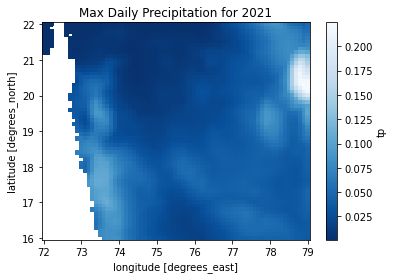

In [20]:
tp_2021_max.plot(cmap='Blues_r')
plt.title('Max Daily Precipitation for 2021')
plt.show()

- The values where we see white space is the coastline of Maharashtra. 
- The most average daily precipitation that we see is in the middle and the west part of the plot. That's the Konkan area. 

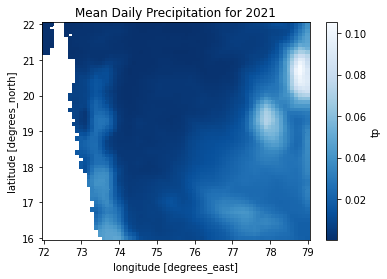

In [21]:
# plot the mean daily precipitation for tp_2021
tp_2021_mean.plot(cmap='Blues_r')
plt.title('Mean Daily Precipitation for 2021')
plt.show()


In [22]:
# max sp for 2021
sp_2021 = data_2021.sp.sel(time=data_2021.time.dt.month == 7).sel(time=data_2021.time.dt.day == 22)
sp_2021_max = sp_2021.max(dim='time')

# mean sp for 2021
sp_2021_mean = sp_2021.mean(dim='time')

# max t2m for 2021
t2m_2021 = data_2021.t2m.sel(time=data_2021.time.dt.month == 7).sel(time=data_2021.time.dt.day == 22)
t2m_2021_max = t2m_2021.max(dim='time')

# mean t2m for 2021
t2m_2021_mean = t2m_2021.mean(dim='time')

# max v10 for 2021
v10_2021 = data_2021.v10.sel(time=data_2021.time.dt.month == 7).sel(time=data_2021.time.dt.day == 22)
v10_2021_max = v10_2021.max(dim='time')

# mean v10 for 2021
v10_2021_mean = v10_2021.mean(dim='time')

# max ssr for 2021
ssr_2021 = data_2021.ssr.sel(time=data_2021.time.dt.month == 7).sel(time=data_2021.time.dt.day == 22)
ssr_2021_max = ssr_2021.max(dim='time')

# mean ssr for 2021
ssr_2021_mean = ssr_2021.mean(dim='time')



In [23]:
# different color maps for ssr, sp, t2m, v10
cmap_ssr = plt.cm.get_cmap('Oranges_r')
cmap_v10 = plt.cm.get_cmap('gist_rainbow_r')
cmap_t2m = plt.cm.get_cmap('magma_r')
cmap_sp = plt.cm.get_cmap('autumn_r')


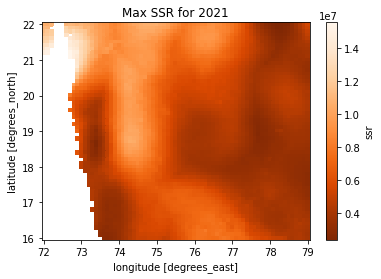

In [24]:
# plot max ssr for 2021
ssr_2021_max.plot(cmap=cmap_ssr)
plt.title('Max SSR for 2021')
plt.show()


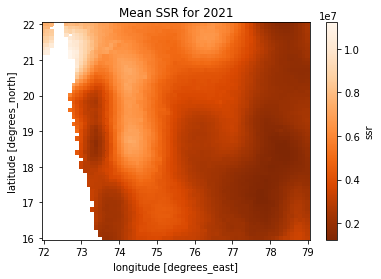

In [25]:
# plot mean ssr for 2021
ssr_2021_mean.plot(cmap=cmap_ssr)
plt.title('Mean SSR for 2021')
plt.show()


- The net solar radiation was around $0.2-0.4$ $W/m^2$, which was not much, as compared to the other parts.

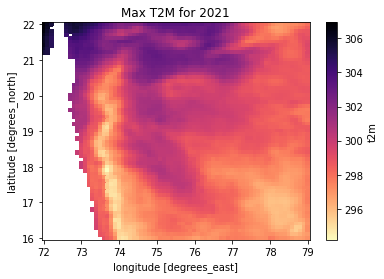

In [26]:
# plot max t2m for 2021
t2m_2021_max.plot(cmap=cmap_t2m)
plt.title('Max T2M for 2021')
plt.show()



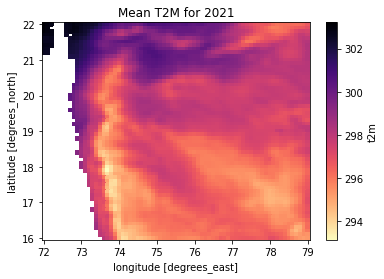

In [27]:
# plot mean t2m for 2021
t2m_2021_mean.plot(cmap=cmap_t2m)
plt.title('Mean T2M for 2021')
plt.show()


- The temperature of air at 2m above the surface of the western part of Maharashtra was between $296-298$ K, expected since it was colder (told by my parents).

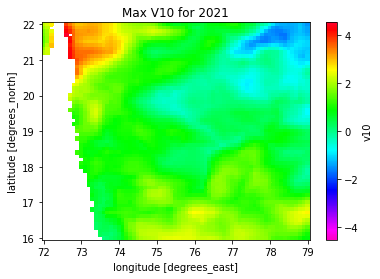

In [28]:
# plot max v10 for 2021
v10_2021_max.plot(cmap=cmap_v10)
plt.title('Max V10 for 2021')
plt.show()


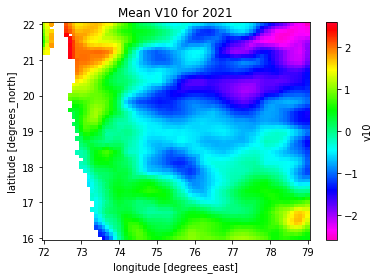

In [29]:
# plot mean v10 for 2021
v10_2021_mean.plot(cmap=cmap_v10)
plt.title('Mean V10 for 2021')
plt.show()


- The wind speed was almost close 0 $m/s$ on the western part of Maharashtra, where Mahad is. 

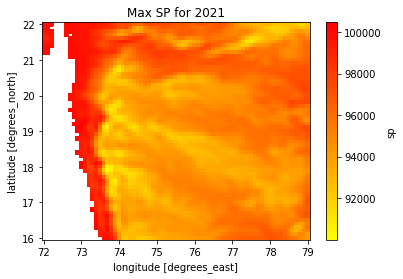

In [30]:
# plot max sp for 2021
sp_2021_max.plot(cmap=cmap_sp)
plt.title('Max SP for 2021')
plt.show()


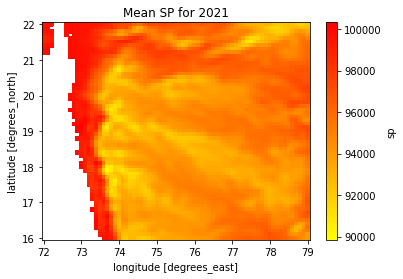

In [31]:
# plot mean sp for 2021
sp_2021_mean.plot(cmap=cmap_sp)
plt.title('Mean SP for 2021')
plt.show()


- The surface pressure could be seen more on the western part of Maharashtra, where Mahad is. 

## Daily Precipitation data at the gridpoint nearest Mahad (latitude: 18.1, longitude: 73.4)

In [32]:
lat = data.latitude.values
lon = data.longitude.values
# Find the indices of the nearest gridpoint to Mahad. Save these indices to new variables, and print out the values. 
lat_mahad = 18.1
# longitude of mahad in eastward
lon_mahad = 73.4
# find the indices of the nearest gridpoint to mahad
lat_ind = np.abs(lat - lat_mahad).argmin()
lon_ind = np.abs(lon - lon_mahad).argmin()
# print the values of the indices
print(f"The latitude index of the nearest gridpoint to Mahad is: {lat_ind}")
print(f"The longitude index of the nearest gridpoint to Mahad is: {lon_ind}")


The latitude index of the nearest gridpoint to Mahad is: 39
The longitude index of the nearest gridpoint to Mahad is: 14


### Lat/long of that gridpoint

In [33]:
# Print the corresponding lat/lon of that gridpoint.
print(f"The corresponding lat/lon of that gridpoint is: {lat[lat_ind]}, {lon[lon_ind]}")

The corresponding lat/lon of that gridpoint is: 18.100000381469727, 73.4000015258789


### data_mahad

In [34]:
# Index your data so that you are only accessing data at this special location.
data_mahad = data.sel(latitude=lat[lat_ind], longitude=lon[lon_ind])
data_mahad

<xarray.Dataset>
Dimensions:    (time: 792)
Coordinates:
    longitude  float32 73.4
    latitude   float32 18.1
  * time       (time) datetime64[ns] 2019-07-14 ... 2021-07-24T23:00:00
Data variables:
    v10        (time) float32 1.36 1.185 1.429 1.556 ... 1.346 1.259 1.416 1.26
    t2m        (time) float32 297.5 297.5 298.0 298.2 ... 297.6 297.4 297.1
    ssr        (time) float32 1.141e+07 6.582e+03 ... 9.002e+06 9.002e+06
    sp         (time) float32 1.003e+05 1.003e+05 ... 9.993e+04 9.995e+04
    tp         (time) float32 0.01479 0.0007439 0.001312 ... 0.0199 0.02092
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-23 20:02:03 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

### Line plot of total precipitation

#### 2019 plot

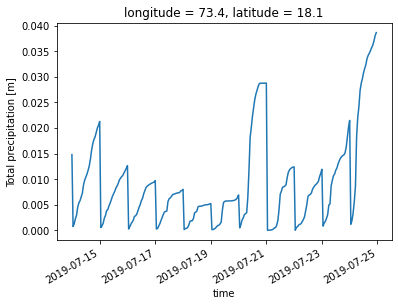

In [35]:
# make a line plot of all the total precip at this location, for all three years separately
data_mahad.tp.sel(time=data_mahad.time.dt.year == 2019).plot()

#### 2020 plot

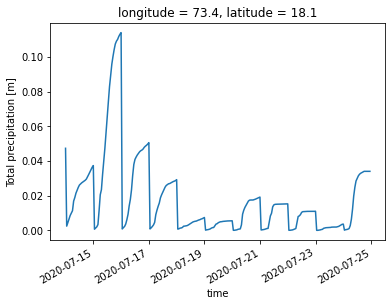

In [36]:
data_mahad.tp.sel(time=data_mahad.time.dt.year == 2020).plot()


#### 2021 plot

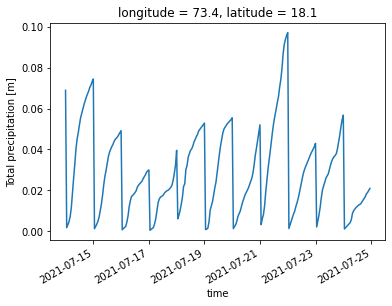

In [37]:
data_mahad.tp.sel(time=data_mahad.time.dt.year == 2021).plot()

- As we can see from the above, in 2021, the rainfall was consistently more than what we could see in 2019 and 2020. 
- If the rainfall is more, the river gets flooded pretty sooner. 
- So, once we know that the rainfall has been consistently more for a few days, we can warn the people to start taking precautions. 

### Basic Statistics

#### Max

In [38]:
# get the maximum total precip for each year
tp_2019_max = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2019).max(dim='time')
tp_2020_max = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2020).max(dim='time')
tp_2021_max = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2021).max(dim='time')
print(f"The maximum total precip for 2019 is: {tp_2019_max.values}")
print(f"The maximum total precip for 2020 is: {tp_2020_max.values}")
print(f"The maximum total precip for 2021 is: {tp_2021_max.values}")

# get the maximum of all variables for each year
# ssr 
ssr_2019_max = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2019).max(dim='time')
ssr_2020_max = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2020).max(dim='time')
ssr_2021_max = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2021).max(dim='time')
print(f"The maximum ssr for 2019 is: {ssr_2019_max.values}")
print(f"The maximum ssr for 2020 is: {ssr_2020_max.values}")
print(f"The maximum ssr for 2021 is: {ssr_2021_max.values}")

# t2m
t2m_2019_max = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2019).max(dim='time')
t2m_2020_max = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2020).max(dim='time')
t2m_2021_max = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2021).max(dim='time')
print(f"The maximum t2m for 2019 is: {t2m_2019_max.values}")
print(f"The maximum t2m for 2020 is: {t2m_2020_max.values}")
print(f"The maximum t2m for 2021 is: {t2m_2021_max.values}")

# v10
v10_2019_max = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2019).max(dim='time')
v10_2020_max = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2020).max(dim='time')
v10_2021_max = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2021).max(dim='time')
print(f"The maximum v10 for 2019 is: {v10_2019_max.values}")
print(f"The maximum v10 for 2020 is: {v10_2020_max.values}")
print(f"The maximum v10 for 2021 is: {v10_2021_max.values}")

# sp
sp_2019_max = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2019).max(dim='time')
sp_2020_max = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2020).max(dim='time')
sp_2021_max = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2021).max(dim='time')
print(f"The maximum sp for 2019 is: {sp_2019_max.values}")
print(f"The maximum sp for 2020 is: {sp_2020_max.values}")
print(f"The maximum sp for 2021 is: {sp_2021_max.values}")



The maximum total precip for 2019 is: 0.038647472858428955
The maximum total precip for 2020 is: 0.11406556516885757
The maximum total precip for 2021 is: 0.09719663858413696
The maximum ssr for 2019 is: 14228702.0
The maximum ssr for 2020 is: 12768257.0
The maximum ssr for 2021 is: 9130712.0
The maximum t2m for 2019 is: 303.75189208984375
The maximum t2m for 2020 is: 303.087890625
The maximum t2m for 2021 is: 300.45404052734375
The maximum v10 for 2019 is: 3.0437960624694824
The maximum v10 for 2020 is: 3.4909563064575195
The maximum v10 for 2021 is: 2.316418409347534
The maximum sp for 2019 is: 100424.4453125
The maximum sp for 2020 is: 100265.7421875
The maximum sp for 2021 is: 100403.6328125


#### Min

In [39]:
# get the minimum total precip for each year
tp_2019_min = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2019).min(dim='time')
tp_2020_min = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2020).min(dim='time')
tp_2021_min = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2021).min(dim='time')
print(f"The minimum total precip for 2019 is: {tp_2019_min.values}")   
print(f"The minimum total precip for 2020 is: {tp_2020_min.values}")
print(f"The minimum total precip for 2021 is: {tp_2021_min.values}")

# get the minimum of all variables for each year
# ssr
ssr_2019_min = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2019).min(dim='time')
ssr_2020_min = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2020).min(dim='time')
ssr_2021_min = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2021).min(dim='time')
print(f"The minimum ssr for 2019 is: {ssr_2019_min.values}")
print(f"The minimum ssr for 2020 is: {ssr_2020_min.values}")
print(f"The minimum ssr for 2021 is: {ssr_2021_min.values}")

# t2m
t2m_2019_min = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2019).min(dim='time')
t2m_2020_min = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2020).min(dim='time')
t2m_2021_min = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2021).min(dim='time')
print(f"The minimum t2m for 2019 is: {t2m_2019_min.values}")
print(f"The minimum t2m for 2020 is: {t2m_2020_min.values}")
print(f"The minimum t2m for 2021 is: {t2m_2021_min.values}")

# v10
v10_2019_min = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2019).min(dim='time')
v10_2020_min = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2020).min(dim='time')
v10_2021_min = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2021).min(dim='time')
print(f"The minimum v10 for 2019 is: {v10_2019_min.values}")
print(f"The minimum v10 for 2020 is: {v10_2020_min.values}")
print(f"The minimum v10 for 2021 is: {v10_2021_min.values}")

# sp
sp_2019_min = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2019).min(dim='time')
sp_2020_min = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2020).min(dim='time')
sp_2021_min = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2021).min(dim='time')
print(f"The minimum sp for 2019 is: {sp_2019_min.values}")
print(f"The minimum sp for 2020 is: {sp_2020_min.values}")
print(f"The minimum sp for 2021 is: {sp_2021_min.values}")


The minimum total precip for 2019 is: 1.5251338481903076e-05
The minimum total precip for 2020 is: 1.1436641216278076e-05
The minimum total precip for 2021 is: 0.000457763671875
The minimum ssr for 2019 is: 1363.0
The minimum ssr for 2020 is: 668.0
The minimum ssr for 2021 is: 320.0
The minimum t2m for 2019 is: 296.7691650390625
The minimum t2m for 2020 is: 296.498779296875
The minimum t2m for 2021 is: 296.5606689453125
The minimum v10 for 2019 is: -1.110135555267334
The minimum v10 for 2020 is: -0.4907798767089844
The minimum v10 for 2021 is: -1.4563539028167725
The minimum sp for 2019 is: 99382.5546875
The minimum sp for 2020 is: 99425.3984375
The minimum sp for 2021 is: 99528.421875


#### Standard deviation

In [40]:
# get the standard deviation of total precip for each year
tp_2019_std = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2019).std(dim='time')
tp_2020_std = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2020).std(dim='time')
tp_2021_std = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2021).std(dim='time')
print(f"The standard deviation of total precip for 2019 is: {tp_2019_std.values}")
print(f"The standard deviation of total precip for 2020 is: {tp_2020_std.values}")
print(f"The standard deviation of total precip for 2021 is: {tp_2021_std.values}")

# get the standard deviation of all variables for each year
# ssr
ssr_2019_std = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2019).std(dim='time')
ssr_2020_std = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2020).std(dim='time')
ssr_2021_std = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2021).std(dim='time')
print(f"The standard deviation of ssr for 2019 is: {ssr_2019_std.values}")
print(f"The standard deviation of ssr for 2020 is: {ssr_2020_std.values}")
print(f"The standard deviation of ssr for 2021 is: {ssr_2021_std.values}")

# t2m
t2m_2019_std = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2019).std(dim='time')
t2m_2020_std = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2020).std(dim='time')
t2m_2021_std = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2021).std(dim='time')
print(f"The standard deviation of t2m for 2019 is: {t2m_2019_std.values}")
print(f"The standard deviation of t2m for 2020 is: {t2m_2020_std.values}")
print(f"The standard deviation of t2m for 2021 is: {t2m_2021_std.values}")

# v10
v10_2019_std = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2019).std(dim='time')
v10_2020_std = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2020).std(dim='time')
v10_2021_std = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2021).std(dim='time')
print(f"The standard deviation of v10 for 2019 is: {v10_2019_std.values}")
print(f"The standard deviation of v10 for 2020 is: {v10_2020_std.values}")
print(f"The standard deviation of v10 for 2021 is: {v10_2021_std.values}")

# sp
sp_2019_std = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2019).std(dim='time')
sp_2020_std = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2020).std(dim='time')
sp_2021_std = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2021).std(dim='time')
print(f"The standard deviation of sp for 2019 is: {sp_2019_std.values}")
print(f"The standard deviation of sp for 2020 is: {sp_2020_std.values}")
print(f"The standard deviation of sp for 2021 is: {sp_2021_std.values}")


The standard deviation of total precip for 2019 is: 0.009008652530610561
The standard deviation of total precip for 2020 is: 0.02299460768699646
The standard deviation of total precip for 2021 is: 0.02097214013338089
The standard deviation of ssr for 2019 is: 4669063.0
The standard deviation of ssr for 2020 is: 4360974.0
The standard deviation of ssr for 2021 is: 2643788.0
The standard deviation of t2m for 2019 is: 1.500083327293396
The standard deviation of t2m for 2020 is: 1.321419596672058
The standard deviation of t2m for 2021 is: 0.699251651763916
The standard deviation of v10 for 2019 is: 0.7549567818641663
The standard deviation of v10 for 2020 is: 0.856518566608429
The standard deviation of v10 for 2021 is: 0.7639433145523071
The standard deviation of sp for 2019 is: 274.2175598144531
The standard deviation of sp for 2020 is: 213.41897583007812
The standard deviation of sp for 2021 is: 188.17091369628906


#### Mean

In [41]:
# get the mean of total precip for each year
tp_2019_mean = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2019).mean(dim='time')
tp_2020_mean = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2020).mean(dim='time')
tp_2021_mean = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2021).mean(dim='time')
print(f"The mean of total precip for 2019 is: {tp_2019_mean.values}")
print(f"The mean of total precip for 2020 is: {tp_2020_mean.values}")
print(f"The mean of total precip for 2021 is: {tp_2021_mean.values}")

# get the mean of all variables for each year
# ssr
ssr_2019_mean = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2019).mean(dim='time')
ssr_2020_mean = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2020).mean(dim='time')
ssr_2021_mean = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2021).mean(dim='time')
print(f"The mean of ssr for 2019 is: {ssr_2019_mean.values}")
print(f"The mean of ssr for 2020 is: {ssr_2020_mean.values}")
print(f"The mean of ssr for 2021 is: {ssr_2021_mean.values}")

# t2m
t2m_2019_mean = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2019).mean(dim='time')
t2m_2020_mean = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2020).mean(dim='time')
t2m_2021_mean = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2021).mean(dim='time')
print(f"The mean of t2m for 2019 is: {t2m_2019_mean.values}")
print(f"The mean of t2m for 2020 is: {t2m_2020_mean.values}")
print(f"The mean of t2m for 2021 is: {t2m_2021_mean.values}")

# v10
v10_2019_mean = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2019).mean(dim='time')
v10_2020_mean = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2020).mean(dim='time')
v10_2021_mean = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2021).mean(dim='time')
print(f"The mean of v10 for 2019 is: {v10_2019_mean.values}")
print(f"The mean of v10 for 2020 is: {v10_2020_mean.values}")
print(f"The mean of v10 for 2021 is: {v10_2021_mean.values}")

# sp
sp_2019_mean = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2019).mean(dim='time')
sp_2020_mean = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2020).mean(dim='time')
sp_2021_mean = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2021).mean(dim='time')
print(f"The mean of sp for 2019 is: {sp_2019_mean.values}")
print(f"The mean of sp for 2020 is: {sp_2020_mean.values}")
print(f"The mean of sp for 2021 is: {sp_2021_mean.values}")


The mean of total precip for 2019 is: 0.00919452402740717
The mean of total precip for 2020 is: 0.017825091257691383
The mean of total precip for 2021 is: 0.028783045709133148
The mean of ssr for 2019 is: 7849041.5
The mean of ssr for 2020 is: 6382346.0
The mean of ssr for 2021 is: 3769202.0
The mean of t2m for 2019 is: 298.9544372558594
The mean of t2m for 2020 is: 298.7690124511719
The mean of t2m for 2021 is: 298.02362060546875
The mean of v10 for 2019 is: 0.9523016214370728
The mean of v10 for 2020 is: 1.2920783758163452
The mean of v10 for 2021 is: 0.7222222089767456
The mean of sp for 2019 is: 99924.375
The mean of sp for 2020 is: 99900.953125
The mean of sp for 2021 is: 99943.28125


#### Interquartile range

In [42]:
# get the iqr of total precip for each year
tp_2019_iqr = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2019).quantile(0.75) - data_mahad.tp.sel(time=data_mahad.time.dt.year == 2019).quantile(0.25)
tp_2020_iqr = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2020).quantile(0.75) - data_mahad.tp.sel(time=data_mahad.time.dt.year == 2020).quantile(0.25)
tp_2021_iqr = data_mahad.tp.sel(time=data_mahad.time.dt.year == 2021).quantile(0.75) - data_mahad.tp.sel(time=data_mahad.time.dt.year == 2021).quantile(0.25)
print(f"The iqr of total precip for 2019 is: {tp_2019_iqr.values}")
print(f"The iqr of total precip for 2020 is: {tp_2020_iqr.values}")
print(f"The iqr of total precip for 2021 is: {tp_2021_iqr.values}")

#  get the iqr of all variables for each year
# ssr
ssr_2019_iqr = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2019).quantile(0.75) - data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2019).quantile(0.25)
ssr_2020_iqr = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2020).quantile(0.75) - data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2020).quantile(0.25)
ssr_2021_iqr = data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2021).quantile(0.75) - data_mahad.ssr.sel(time=data_mahad.time.dt.year == 2021).quantile(0.25)
print(f"The iqr of ssr for 2019 is: {ssr_2019_iqr.values}")
print(f"The iqr of ssr for 2020 is: {ssr_2020_iqr.values}")
print(f"The iqr of ssr for 2021 is: {ssr_2021_iqr.values}")

# t2m
t2m_2019_iqr = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2019).quantile(0.75) - data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2019).quantile(0.25)
t2m_2020_iqr = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2020).quantile(0.75) - data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2020).quantile(0.25)
t2m_2021_iqr = data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2021).quantile(0.75) - data_mahad.t2m.sel(time=data_mahad.time.dt.year == 2021).quantile(0.25)
print(f"The iqr of t2m for 2019 is: {t2m_2019_iqr.values}")
print(f"The iqr of t2m for 2020 is: {t2m_2020_iqr.values}")
print(f"The iqr of t2m for 2021 is: {t2m_2021_iqr.values}")

# v10
v10_2019_iqr = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2019).quantile(0.75) - data_mahad.v10.sel(time=data_mahad.time.dt.year == 2019).quantile(0.25)
v10_2020_iqr = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2020).quantile(0.75) - data_mahad.v10.sel(time=data_mahad.time.dt.year == 2020).quantile(0.25)
v10_2021_iqr = data_mahad.v10.sel(time=data_mahad.time.dt.year == 2021).quantile(0.75) - data_mahad.v10.sel(time=data_mahad.time.dt.year == 2021).quantile(0.25)
print(f"The iqr of v10 for 2019 is: {v10_2019_iqr.values}")
print(f"The iqr of v10 for 2020 is: {v10_2020_iqr.values}")
print(f"The iqr of v10 for 2021 is: {v10_2021_iqr.values}")

# sp
sp_2019_iqr = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2019).quantile(0.75) - data_mahad.sp.sel(time=data_mahad.time.dt.year == 2019).quantile(0.25)
sp_2020_iqr = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2020).quantile(0.75) - data_mahad.sp.sel(time=data_mahad.time.dt.year == 2020).quantile(0.25)
sp_2021_iqr = data_mahad.sp.sel(time=data_mahad.time.dt.year == 2021).quantile(0.75) - data_mahad.sp.sel(time=data_mahad.time.dt.year == 2021).quantile(0.25)
print(f"The iqr of sp for 2019 is: {sp_2019_iqr.values}")
print(f"The iqr of sp for 2020 is: {sp_2020_iqr.values}")
print(f"The iqr of sp for 2021 is: {sp_2021_iqr.values}")


The iqr of total precip for 2019 is: 0.008935155346989632
The iqr of total precip for 2020 is: 0.02425815351307392
The iqr of total precip for 2021 is: 0.03104749694466591
The iqr of ssr for 2019 is: 7711432.875
The iqr of ssr for 2020 is: 8161690.125
The iqr of ssr for 2021 is: 3633109.5
The iqr of t2m for 2019 is: 2.0300369262695312
The iqr of t2m for 2020 is: 1.5544052124023438
The iqr of t2m for 2021 is: 0.7313919067382812
The iqr of v10 for 2019 is: 0.7506721019744873
The iqr of v10 for 2020 is: 1.0630333125591278
The iqr of v10 for 2021 is: 1.0843294262886047
The iqr of sp for 2019 is: 476.15625
The iqr of sp for 2020 is: 299.974609375
The iqr of sp for 2021 is: 271.87109375


In [43]:
# get the table of max, min, mean, std, and iqr for each variable 
# for each year
# for 2019 table of max, min, mean, std, and iqr
table_2019 = pd.DataFrame({'Variable2019': ['tp', 'ssr', 't2m', 'v10', 'sp'], 
                            'Max': [tp_2019_max.values, ssr_2019_max.values, t2m_2019_max.values, v10_2019_max.values, sp_2019_max.values],
                            'Min': [tp_2019_min.values, ssr_2019_min.values, t2m_2019_min.values, v10_2019_min.values, sp_2019_min.values],
                            'Mean': [tp_2019_mean.values, ssr_2019_mean.values, t2m_2019_mean.values, v10_2019_mean.values, sp_2019_mean.values],
                            'Std': [tp_2019_std.values, ssr_2019_std.values, t2m_2019_std.values, v10_2019_std.values, sp_2019_std.values],
                            'IQR': [tp_2019_iqr.values, ssr_2019_iqr.values, t2m_2019_iqr.values, v10_2019_iqr.values, sp_2019_iqr.values]})
# for 2020 table of max, min, mean, std, and iqr
table_2020 = pd.DataFrame({'Variable2020': ['tp', 'ssr', 't2m', 'v10', 'sp'],
                            'Max': [tp_2020_max.values, ssr_2020_max.values, t2m_2020_max.values, v10_2020_max.values, sp_2020_max.values],
                            'Min': [tp_2020_min.values, ssr_2020_min.values, t2m_2020_min.values, v10_2020_min.values, sp_2020_min.values],
                            'Mean': [tp_2020_mean.values, ssr_2020_mean.values, t2m_2020_mean.values, v10_2020_mean.values, sp_2020_mean.values],
                            'Std': [tp_2020_std.values, ssr_2020_std.values, t2m_2020_std.values, v10_2020_std.values, sp_2020_std.values],
                            'IQR': [tp_2020_iqr.values, ssr_2020_iqr.values, t2m_2020_iqr.values, v10_2020_iqr.values, sp_2020_iqr.values]})

# for 2021 table of max, min, mean, std, and iqr
table_2021 = pd.DataFrame({'Variable2021': ['tp', 'ssr', 't2m', 'v10', 'sp'],
                            'Max': [tp_2021_max.values, ssr_2021_max.values, t2m_2021_max.values, v10_2021_max.values, sp_2021_max.values],
                            'Min': [tp_2021_min.values, ssr_2021_min.values, t2m_2021_min.values, v10_2021_min.values, sp_2021_min.values],
                            'Mean': [tp_2021_mean.values, ssr_2021_mean.values, t2m_2021_mean.values, v10_2021_mean.values, sp_2021_mean.values],
                            'Std': [tp_2021_std.values, ssr_2021_std.values, t2m_2021_std.values, v10_2021_std.values, sp_2021_std.values],
                            'IQR': [tp_2021_iqr.values, ssr_2021_iqr.values, t2m_2021_iqr.values, v10_2021_iqr.values, sp_2021_iqr.values]})

# convert the table to pdf
table_2019.to_latex('table_2019.tex', index=False)
table_2020.to_latex('table_2020.tex', index=False)
table_2021.to_latex('table_2021.tex', index=False)

# convert the table to csv
table_2019.to_csv('table_2019.csv', index=False)
table_2020.to_csv('table_2020.csv', index=False)
table_2021.to_csv('table_2021.csv', index=False)


**2019**

![2019](images/2019_table.png)

**2020**

![2020](images/2020_table.png)

**2021**

![2021](images/2021_table.png)

- On 22nd July, 2021, the maximum precipitation in Mahad was $97.2$ mm.
- The minimum precipitation in Mahad was $0.46$ mm. 
- The standard deviation of precipitation in Mahad was $20.9$ mm. 
- The mean precipitation in Mahad was $28.78$ mm. 
- The interquartile range was $31.05$ mm. 

**More analysis:**
- The unit of tp is `m`. 
- The maximum precipitation had been $114$ mm (maximum of all years) in 2020, but since the mean value was $17.9$ mm that is lower than the mean value of 28.8 mm in 2021, the rainfall occurred only for a small period of time in 2020.
- But, the rainfall in 2021 occurred for a longer period of time or the maximum rainfall occurred in short periods of time multiple times. The floods would be the result of the accumulation of water in the river `Savitri` in a short period of time. Since the river is narrow, there was flood.

## Total Precipitation for 6 consecutive days of July, 2021

- It's clear that some anomaly had taken place on July 22, 2021. The people experience "Cloudburst" (https://en.wikipedia.org/wiki/Cloudburst). Did cloudburst occur on prior days to July 22, 2021?

- I have plotted the maximum precipitation on 5 days prior to July 22, 2021 on the same plot.

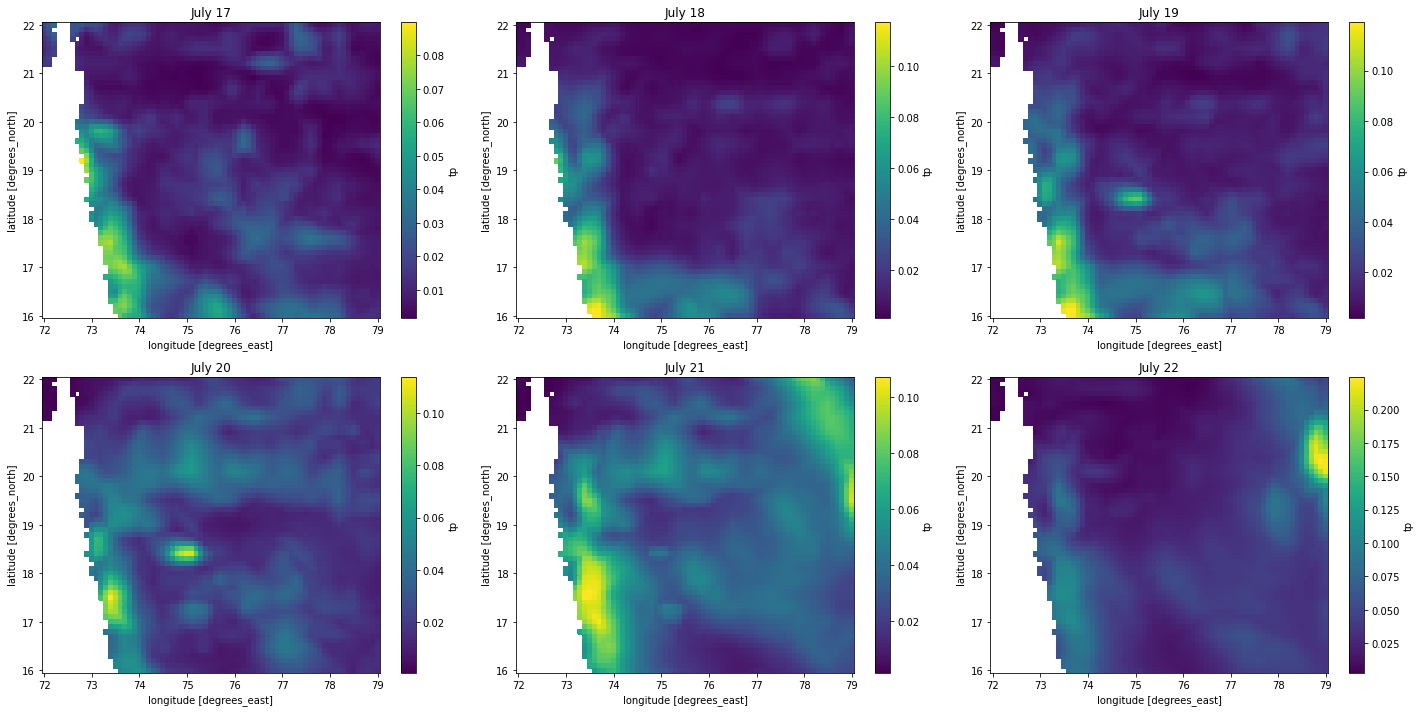

In [44]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize = (20, 10))
# get the maximum value of total precipitation for July 17, 18, 19, 20, 21, 22 of 2021 and plot it on the graph
data.tp.sel(time=data.time.dt.month == 7).sel(time=data.time.dt.day == 17).max(dim='time').plot(ax=axes[0, 0], label='July 17')
data.tp.sel(time=data.time.dt.month == 7).sel(time=data.time.dt.day == 18).max(dim='time').plot(ax=axes[0, 1], label='July 18')
data.tp.sel(time=data.time.dt.month == 7).sel(time=data.time.dt.day == 19).max(dim='time').plot(ax=axes[0, 2], label='July 19')
data.tp.sel(time=data.time.dt.month == 7).sel(time=data.time.dt.day == 20).max(dim='time').plot(ax=axes[1, 0], label='July 20')
data.tp.sel(time=data.time.dt.month == 7).sel(time=data.time.dt.day == 21).max(dim='time').plot(ax=axes[1, 1], label='July 21')
data.tp.sel(time=data.time.dt.month == 7).sel(time=data.time.dt.day == 22).max(dim='time').plot(ax=axes[1, 2], label='July 22')

axes[0, 0].set_title('July 17')
axes[0, 1].set_title('July 18')
axes[0, 2].set_title('July 19')
axes[1, 0].set_title('July 20')
axes[1, 1].set_title('July 21')
axes[1, 2].set_title('July 22')

fig.tight_layout()
plt.show()

- As we can see that maximum rainfall occurred on days prior to July 22, 2021. This could be the reason that the river Savitri got flooded sooner than observed in the previous years. 

## Mahabaleshwar - Total Precipitation for 6 consecutive days of July, 2021

- Mahabaleshwar is a hillstation, where Savitri river originates. 

In [45]:
# get the location of Mahabaleshwar, Maharashtra, India
lat_mahabaleshwar = 17.93
lon_mahabaleshwar = 73.65
lat = data.latitude.values
lon = data.longitude.values

# find the indices of the nearest point to Mahabaleshwar. Save these indices to new variables, and print out the values. 
lat_ind_mahabaleshwar = np.abs(lat - lat_mahabaleshwar).argmin()
lon_ind_mahabaleshwar = np.abs(lon - lon_mahabaleshwar).argmin()
# print(lat_ind_mahabaleshwar, lon_ind_mahabaleshwar)
print(f"The latitude index of the nearest gridpoint to Mahabaleshwar is : {lat_ind_mahabaleshwar}")
print(f"The longitude index of the nearest gridpoint to Mahabaleshwar is : {lon_ind_mahabaleshwar}")

The latitude index of the nearest gridpoint to Mahabaleshwar is : 41
The longitude index of the nearest gridpoint to Mahabaleshwar is : 17


### Lat/long of that gridpoint

In [46]:
# Print the corresponding lat/lon of that gridpoint.
print(f"The corresponding lat/lon of that gridpoint is : {lat[lat_ind_mahabaleshwar]}, {lon[lon_ind_mahabaleshwar]}")


The corresponding lat/lon of that gridpoint is : 17.899999618530273, 73.69999694824219


### data_mahabaleshwar   

In [47]:
# Index your data so that you are only accessing data at this special location.
data_mahabaleshwar = data.sel(latitude=lat[lat_ind_mahabaleshwar], longitude=lon[lon_ind_mahabaleshwar])
data_mahabaleshwar

<xarray.Dataset>
Dimensions:    (time: 792)
Coordinates:
    longitude  float32 73.7
    latitude   float32 17.9
  * time       (time) datetime64[ns] 2019-07-14 ... 2021-07-24T23:00:00
Data variables:
    v10        (time) float32 1.141 0.987 1.05 1.109 ... 1.018 0.9681 0.8923
    t2m        (time) float32 293.5 293.3 293.5 293.6 ... 293.3 293.2 292.7
    ssr        (time) float32 1.119e+07 4.842e+03 ... 1.005e+07 1.005e+07
    sp         (time) float32 9.031e+04 9.033e+04 ... 8.998e+04 8.999e+04
    tp         (time) float32 0.01136 0.0003281 0.001457 ... 0.02359 0.02457
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-23 20:02:03 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

### Line plot of total precipitation

#### 2019 plot

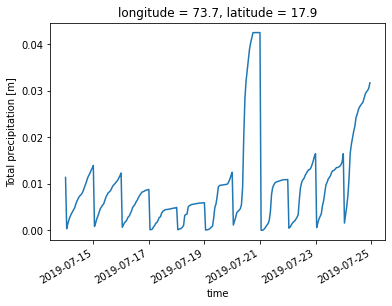

In [48]:
# make a line plot of all the total precip at this location, for all three years separately
data_mahabaleshwar.tp.sel(time=data_mahabaleshwar.time.dt.year == 2019).plot(label='2019')

#### 2020 plot

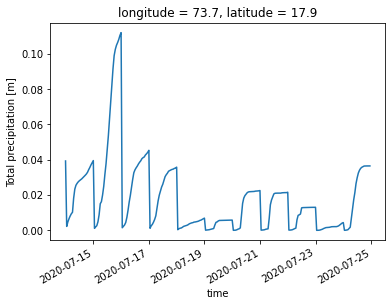

In [49]:
# make a line plot of all the total precip at this location, for all three years separately
data_mahabaleshwar.tp.sel(time=data_mahabaleshwar.time.dt.year == 2020).plot(label='2020')


#### 2021 plot

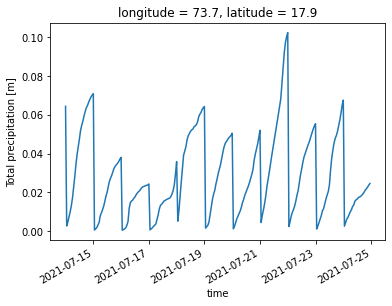

In [50]:
# make a line plot of all the total precip at this location, for all three years separately
data_mahabaleshwar.tp.sel(time=data_mahabaleshwar.time.dt.year == 2021).plot(label='2021')

- As we can see from the above, in 2021, the rainfall was consistently more than what we could see in 2019 and 2020. 
- If the rainfall is more, the river gets flooded pretty sooner. So, once we know that the rainfall has been consistently more for a few days, we can warn the people to start taking precautions. - Also, the precipitation values in Mahabaleshwar and Mahad are similar. There is not much difference. 

## Challenges

- I had initially downloaded the data for the entire country of India. But, it would be irrelevant to the aim of this project, and the size was 400 mb in total. So, I downloaded the data pertaining to the Maharashtra state, where my hometown is. 

- We will also be transforming the data for deep neural networks for forecasting.